# Mempool Data preprocessing to JSON array 

In [1]:
import json 
import os.path
import math
import matplotlib.pyplot as plt
import numpy as np

FIRST_BLOCK_HEIGHT_DURING_CONGESTION = 498084
FIRST_BLOCK_HEIGHT_BEFORE_CONGESTION = 497928
FIRST_BLOCK_NO_CONGESTION = 716644

MEMPOOL_DIR_DURING_CONGESTION = "mempool-during-congestion"
MEMPOOL_DIR_BEFORE_CONGESTION = "mempool-before-congestion"
MEMPOOL_DIR_NO_CONGESTION = "mempool-no-congestion"

# Edges crossed by the Max-Cut, computed with the weigthed imbalanced-max-cut Greedy procedure, 
# with data obtained on May, 2022
MAX_CUT_SIZE = 58531 # 63251 for unweighted
MAX_CUT_CAPACITY = 246436727385 # Weighted

LN_CLOSING_CHANNEL_DELAY = 1000 # ~ 1 week

# We read the JSON file containing blocks data (height, number of transactions)

blocks_file = open(f"blocks/blocks.json", mode = 'r')
blocks_data_content = blocks_file.read()
blocks_data = json.loads(blocks_data_content)

# We read the file containing mempool historical data

FIRST_BLOCK_HEIGHT = FIRST_BLOCK_HEIGHT_DURING_CONGESTION
MEMPOOL_DIR = MEMPOOL_DIR_DURING_CONGESTION

i = 1
mempool_data_json_string = ''

while os.path.exists(f"{MEMPOOL_DIR}/{i}_mempool"):
    mempool_data_file = open(f"{MEMPOOL_DIR}/{i}_mempool", mode = 'r')
    mempool_data_content = mempool_data_file.read()
    
    # We replace call() from file content (it is used for the website to load the JSONP)
    mempool_data_content = mempool_data_content[5 : len(mempool_data_content) - 2]
    
    # We remove the first and the last square brackets, then I will add them again at the end before parsing the JSON,
    # in order to obtain a single merged json of all the mempool data
    mempool_data_content = mempool_data_content[1:]
    mempool_data_content = mempool_data_content[:-1]

    mempool_data_content += ','

    mempool_data_json_string += mempool_data_content
    mempool_data_file.close()

    i += 1

mempool_data_json_string = mempool_data_json_string[:-1]
mempool_data_json_string = f"[{mempool_data_json_string}]"

# Parsing JSON file

mempool_data = json.loads(mempool_data_json_string) 

# Zombie Attack Simulation using mempool historical data

In [2]:
# Data taken from https://jochen-hoenicke.de/queue/#BTC,all,count

# These are the fee ranges supported in the dataset (for example txs that have a fee rate from 10 to 12 with 12 excluded are grouped together and so on)
fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

# Problematic intervals that should not be considerated (probably the BTC nodes of the owner went offline for a while)
PROBLEMATIC_INTERVALS = [[1516728783, 1516729440], [1515943500, 1515944160]] 

# Simulate the Zombie Attack given mempool snapshots for a certain time frame
def simulate(mempool_data, blocks_data, first_block_height_of_simulation, fee_index_in_ranges, num_zombie_channels, highest_priority=False, dynamic=False, beta=1.01, step=1, plot_distribution=False, return_half_channels_closed=False, sample_channel_closing_times=False):
    first_height = blocks_data[0]["height"]
    blocksCounter = 0
    last_total_tx_count = None
    last_tx_count_per_fee_level = None 
    initial_tx_with_same_fee = 0 # Number of transactions with the same fee as the closing channel txs, at the beginning of the simulation
    current_fee = fee_ranges[fee_index_in_ranges]
    num_zombie_channel_before_simulation = num_zombie_channels 

    # Used to return the distribution of closed zombie channels as a function of time, measured in blocks
    plot_blocks = []
    plot_remaining_zombie_channels = []
    
    # Used to record when every channel is closed, used to compute average waiting time for a channel to be closed
    channel_closing_confirmation_samples = []
    
    if not highest_priority:
        initial_tx_with_same_fee = mempool_data[0][1][fee_index_in_ranges]

    for snapshot in mempool_data:
        timestamp = snapshot[0]
        tx_count_per_fee_level = snapshot[1] # Array that contains, for each fee level in `fee_ranges`, the corresponding number of transactions currently in the mempool
        total_tx_count = sum(tx_count_per_fee_level)

        if last_total_tx_count is None and last_tx_count_per_fee_level is None:
            # First snapshot
            last_total_tx_count = total_tx_count
            last_tx_count_per_fee_level = tx_count_per_fee_level
        else:
            is_in_problematic_interval = False

            for interval in PROBLEMATIC_INTERVALS:
                if timestamp >= interval[0] and timestamp < interval[1]:
                    is_in_problematic_interval = True
                    break

            if not is_in_problematic_interval and total_tx_count < last_total_tx_count:
                
                # New Block detected
                blocksCounter += 1
                
                # `first_block_height_of_simulation` is the first block that we will encounter in our simulation (must be manually found using a block explorer)
                # `first_height` is the first blocck number in our blocks dataset
                # These two parameter could differ based on the collected block dataset and the time frame taken into consideration for the simulation.
                num_tx_in_block = blocks_data[(first_block_height_of_simulation - first_height + blocksCounter) - 1]["n_transactions"]
                tx_with_higher_fee = 0 # Number of transactions that have an higher fee than the closing channel transactions
                index = fee_index_in_ranges + 1

                while index < len(tx_count_per_fee_level):
                    tx_with_higher_fee = tx_with_higher_fee + last_tx_count_per_fee_level[index]
                    index = index + 1

                if num_tx_in_block > tx_with_higher_fee: 
                    
                    # The new block can contain transactions with the level of fee we are considering for closing channel transactions
                    
                    number_of_confirmed_tx_in_this_fee_level = num_tx_in_block - tx_with_higher_fee 

                    if initial_tx_with_same_fee >= number_of_confirmed_tx_in_this_fee_level:
                        initial_tx_with_same_fee -= number_of_confirmed_tx_in_this_fee_level
                    else:
                        if initial_tx_with_same_fee > 0:
                            number_of_confirmed_tx_in_this_fee_level -= initial_tx_with_same_fee
                            initial_tx_with_same_fee = 0

                        # In this case, differently from the other type of attack, we dont have to take into account
                        # the fact that the LN transactions that we are monitoring are "replacing" some other transactions that
                        # are removed from the mempool in the dataset, because they would be confirmed after all the LN txs (LN txs in this
                        # case are considered as simultaneously submitted, they are "grouped" together), therefore we are not interested
                        # in keeping track of them.

                        prev_num_zombie_channels = num_zombie_channels
                        num_zombie_channels = max(num_zombie_channels - number_of_confirmed_tx_in_this_fee_level, 0)

                        channel_closing_confirmation_samples.extend([blocksCounter for _ in range(prev_num_zombie_channels - num_zombie_channels)]) 

                if dynamic and blocksCounter % step == 0:
                    new_fee = current_fee * beta
                    fee_index_in_ranges = find_index_of_fee_in_ranges(new_fee)
                    current_fee = new_fee

                if plot_distribution:
                    plot_blocks.append(blocksCounter) 
                    plot_remaining_zombie_channels.append(num_zombie_channels)

            last_total_tx_count = total_tx_count
            last_tx_count_per_fee_level = tx_count_per_fee_level

        if return_half_channels_closed and num_zombie_channels <= (num_zombie_channel_before_simulation / 2): # Used for median time to close a channel
            return blocksCounter      

        if num_zombie_channels <= 0: 
            if plot_distribution:
                return blocksCounter, plot_blocks, plot_remaining_zombie_channels  
            if sample_channel_closing_times:
                return sum(channel_closing_confirmation_samples) / num_zombie_channel_before_simulation # return average waiting time to close a channel
            return blocksCounter

    return None

def find_index_of_fee_in_ranges(fee):
    fee_index = 0
    i = 1

    while i < len(fee_ranges):
        if fee_ranges[i-1] <= fee and fee < fee_ranges[i]:
            fee_index = i-1
            return fee_index
        i = i + 1

    return len(fee_ranges) - 1 # maximum fee index

def get_median_index_fee(first_snapshot):

    initial_tx_count_per_fee_level = first_snapshot[1]
    initial_tx_count_per_fee_level = initial_tx_count_per_fee_level[1:]
    total_tx_count = sum(initial_tx_count_per_fee_level)

    # Computing the index of the median fee in `fee_ranges` (in the first snapshot of the simulation)

    acc = 0
    i = 0
    median_index = 0

    for c in initial_tx_count_per_fee_level:
        acc = acc + c
        if acc >= total_tx_count / 2:
            # As soon as we detected that half of all the txs in the mempool have a lower fee 
            # than the current fee index (and half have an higher fee), than this is the median fee index
            median_index = i
            break
        else:
            i = i + 1  

    return median_index    
       
def get_average_index_fee(first_snapshot): 

    initial_tx_count_per_fee_level = first_snapshot[1]
    initial_tx_count_per_fee_level = initial_tx_count_per_fee_level[1:]
    total_tx_count = sum(initial_tx_count_per_fee_level)

    # Computing the index of the average fee in `fee_ranges` (in the first snapshot of the simulation)

    acc = 0
    i = 0

    while(i < len(initial_tx_count_per_fee_level)):
        acc = acc + (fee_ranges[i] * initial_tx_count_per_fee_level[i])
        i = i + 1

    avg_fee = acc / total_tx_count
    average_index = find_index_of_fee_in_ranges(avg_fee)

    return average_index    

# STATIC CASE

# Remaining Zombie Channels to close as a function of elapsed time (in blocks), for various fee used by the victims

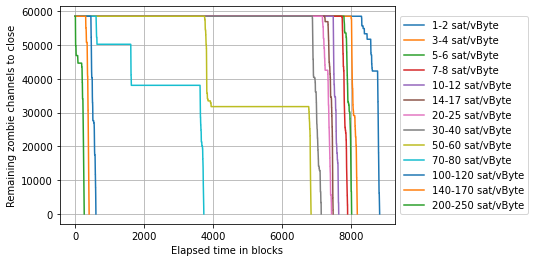

In [3]:
fig, ax = plt.subplots()
ax.grid(True) 

fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

fee_indexes = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]

plot_blocks_array = []
plot_remaining_zombie_channels_array = []
labels = []

for fee_index in fee_indexes:
    needed_blocks, plot_blocks, plot_remaining_zombie_channels = simulate(mempool_data, blocks_data, FIRST_BLOCK_HEIGHT, fee_index, MAX_CUT_SIZE, plot_distribution=True)
    plot_blocks_array.append(plot_blocks)
    plot_remaining_zombie_channels_array.append(plot_remaining_zombie_channels)
    plt.plot(plot_blocks, plot_remaining_zombie_channels)
    labels.append(f"{fee_ranges[fee_index]}-{fee_ranges[fee_index + 1]} sat/vByte")

plt.xlabel('Elapsed time in blocks') 
plt.ylabel(f'Remaining zombie channels to close')
plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Simulation considering all the fee levels supported by the dataset (blocks needed to close all channels as a function of the fee chosen for the closing channels transactions)

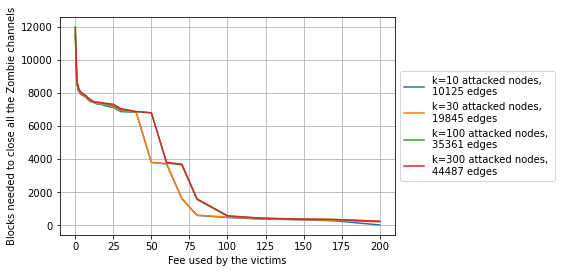

In [4]:
fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200]

fig, ax = plt.subplots()
ax.grid(True)
labels = []

attacked_fractions_of_max_cut = [
    {
        "k" : 10,
        "capacity" : 115024970624,
        "edges" : 10125
    },
    {
        "k" : 30,
        "capacity" : 167165600785,
        "edges" : 19845
    },
    {
        "k" : 100,
        "capacity" : 210496850450,
        "edges" : 35361
    },
    {
        "k" : 300,
        "capacity" : 231206098635,
        "edges" : 44487
    },
]

for fraction in attacked_fractions_of_max_cut:
    k = fraction["k"]
    capacity = fraction["capacity"]
    zombie_channels = fraction["edges"]
    needed_blocks = [] # number of blocks needed to close all the zombie channels

    i = 0
    while i < len(fee_ranges):
        blocks_to_close_all_channels = simulate(mempool_data, blocks_data, FIRST_BLOCK_HEIGHT, i, zombie_channels)
        needed_blocks.append(blocks_to_close_all_channels)
        i += 1
    plt.plot(fee_ranges, needed_blocks)
    labels.append(f"k={k} attacked nodes, \n{zombie_channels} edges")

plt.xlabel('Fee used by the victims') 
plt.ylabel(f'Blocks needed to close all the Zombie channels')
plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


# DYNAMIC CASE

# Simulation with a fixed number of initial zombie channels, fixed alpha parameter, fixed beta (factor of growth of the fee of the transactions still to be confirmed): blocks needed to close all zombie channels as a function of step parameter

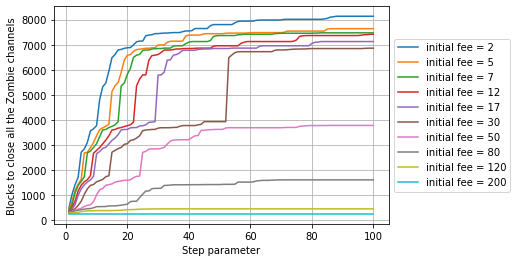

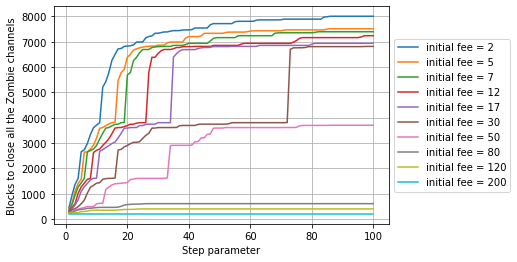

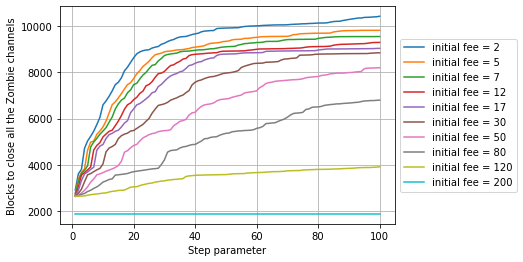

In [5]:
# Dynamic Case
# beta: factor of growth of the fee (new_fee = alpha * beta)
# step: number of blocks after which the fee is increased

fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200]

legend = []
alphas = np.linspace(0.1, 1, num=10)
beta = 1.01 # 1 percent fixed
steps = np.linspace(1, 100, num=100)

fig, ax = plt.subplots()
ax.grid(True)

for alpha in alphas:

    highest_priority = False

    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

    if(fee_index_in_ranges > len(fee_ranges) - 1):
        highest_priority = True
        fee_index_in_ranges = len(fee_ranges) - 1

    initial_fee = fee_ranges[fee_index_in_ranges]

    needed_blocks = []

    for step in steps:
        needed_blocks.append(simulate(mempool_data, blocks_data, FIRST_BLOCK_HEIGHT, fee_index_in_ranges, MAX_CUT_SIZE, highest_priority=highest_priority, dynamic=True, beta=beta, step=step))

    legend.append(f"initial fee = {initial_fee}") 

    plt.plot(steps, needed_blocks)

plt.xlabel('Step parameter') 
plt.ylabel('Blocks to close all the Zombie channels') 
plt.legend(labels=legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

######

attacked_fraction_of_max_cut = {
    "k" : 30,
    "capacity" : 167165600785,
    "edges" : 19845
}
legend = []
alphas = np.linspace(0.1, 1, num=10)
beta = 1.01 # 1 percent fixed
steps = np.linspace(1, 100, num=100)

fig, ax = plt.subplots()
ax.grid(True)

for alpha in alphas:

    highest_priority = False

    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

    if(fee_index_in_ranges > len(fee_ranges) - 1):
        highest_priority = True
        fee_index_in_ranges = len(fee_ranges) - 1

    initial_fee = fee_ranges[fee_index_in_ranges]

    needed_blocks = []

    for step in steps:
        needed_blocks.append(simulate(mempool_data, blocks_data, FIRST_BLOCK_HEIGHT, fee_index_in_ranges, attacked_fraction_of_max_cut["edges"], highest_priority=highest_priority, dynamic=True, beta=beta, step=step))

    legend.append(f"initial fee = {initial_fee}") 

    plt.plot(steps, needed_blocks)

plt.xlabel('Step parameter') 
plt.ylabel('Blocks to close all the Zombie channels') 
plt.legend(labels=legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

######

fig, ax = plt.subplots()
ax.grid(True)

for alpha in alphas:

    highest_priority = False

    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

    if(fee_index_in_ranges > len(fee_ranges) - 1):
        highest_priority = True
        fee_index_in_ranges = len(fee_ranges) - 1

    initial_fee = fee_ranges[fee_index_in_ranges]

    needed_blocks = []

    for step in steps:
        # Not considering the delay here
        needed_blocks.append(simulate(mempool_data, blocks_data, FIRST_BLOCK_HEIGHT, fee_index_in_ranges, 1000000, highest_priority=highest_priority, dynamic=True, beta=beta, step=step))

    legend.append(f"initial fee = {initial_fee}")

    plt.plot(steps, needed_blocks)

plt.xlabel('Step parameter') 
plt.ylabel('Blocks to close all the Zombie channels') 
plt.legend(labels=legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



  

# Cost for users (using Time Value of Money)

In [6]:
fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]
def get_mempool_data(mempool_dir):
    i = 1
    mempool_data_json_string = ''

    while os.path.exists(f"{mempool_dir}/{i}_mempool"):
        mempool_data_file = open(f"{mempool_dir}/{i}_mempool", mode = 'r')
        mempool_data_content = mempool_data_file.read()
        
        # We replace call() from file content (it is used for the website to load the JSONP)
        mempool_data_content = mempool_data_content[5 : len(mempool_data_content) - 2]
        
        # We remove the first and the last square brackets, then I will add them again at the end before parsing the JSON,
        # in order to obtain a single merged json of all the mempool data
        mempool_data_content = mempool_data_content[1:]
        mempool_data_content = mempool_data_content[:-1]

        mempool_data_content += ','

        mempool_data_json_string += mempool_data_content
        mempool_data_file.close()

        i += 1

    mempool_data_json_string = mempool_data_json_string[:-1]
    mempool_data_json_string = f"[{mempool_data_json_string}]"

    # Parsing JSON file

    mempool_data = json.loads(mempool_data_json_string)
    return mempool_data

###

AVERAGE_LND_CLOSING_CHANNEL_DELAY = 529
interests = [0.1]
scenarios = [1, 2]
scenarios_params = {
    1: {
        "FIRST_BLOCK_HEIGHT": FIRST_BLOCK_HEIGHT_DURING_CONGESTION,
        "MEMPOOL_DATA": get_mempool_data(MEMPOOL_DIR_DURING_CONGESTION)
    },
    2: {
        "FIRST_BLOCK_HEIGHT": FIRST_BLOCK_NO_CONGESTION,
        "MEMPOOL_DATA": get_mempool_data(MEMPOOL_DIR_NO_CONGESTION)
    }
}

attacked_fractions_of_max_cut = [
    {
        "k" : 30,
        "capacity" : 1671.65600785, # BTC
        "edges" : 19845
    },
    {
        "k" : 50,
        "capacity" : 1874.01441,
        "edges" : 26137
    },
    {
        "k" : 200,
        "capacity" : 2254.94602646,
        "edges" : 42017
    },
]

# Static
for scenario in scenarios:
    first_block_height = scenarios_params[scenario]["FIRST_BLOCK_HEIGHT"]
    mempool_data = scenarios_params[scenario]["MEMPOOL_DATA"]

    for interest in interests:
        for fraction in attacked_fractions_of_max_cut:
            k = fraction["k"]
            capacity = fraction["capacity"]
            edges = fraction["edges"]
            avg_blocks_to_close_a_channel = simulate(mempool_data, blocks_data, first_block_height, get_average_index_fee(mempool_data[0]), edges, sample_channel_closing_times=True)
            print(f"Average waiting time to close a channel: {avg_blocks_to_close_a_channel}" )
            avg_blocks_to_close_a_channel += AVERAGE_LND_CLOSING_CHANNEL_DELAY 
            PV = capacity 
            blocks_in_a_year = 144 * 365
            FV = PV * pow((1 + interest), avg_blocks_to_close_a_channel/blocks_in_a_year)
            print(f"Scenario {scenario}, k={k}, capacity={capacity}, interest={interest}, FV-PV={FV-PV:2.3f}, STATIC\n")

# Dynamic
for scenario in scenarios:
    first_block_height = scenarios_params[scenario]["FIRST_BLOCK_HEIGHT"]
    mempool_data = scenarios_params[scenario]["MEMPOOL_DATA"]

    for interest in interests:
        for fraction in attacked_fractions_of_max_cut:
            k = fraction["k"]
            capacity = fraction["capacity"]
            edges = fraction["edges"]
            avg_blocks_to_close_a_channel = simulate(mempool_data, blocks_data, first_block_height, get_average_index_fee(mempool_data[0]), edges, dynamic=True, beta=1.01, step=6, sample_channel_closing_times=True) # LN_DELAY
            print(f"Average waiting time to close a channel: {avg_blocks_to_close_a_channel}" )
            avg_blocks_to_close_a_channel += AVERAGE_LND_CLOSING_CHANNEL_DELAY 
            PV = capacity
            blocks_in_a_year = 144 * 365
            FV = PV * pow((1 + interest), avg_blocks_to_close_a_channel/blocks_in_a_year) 
            print(f"Scenario {scenario}, k={k}, capacity={capacity}, interest={interest}, FV-PV={FV-PV:2.3f}, DYNAMIC\n")

Average waiting time to close a channel: 1196.460619803477
Scenario 1, k=30, capacity=1671.65600785, interest=0.1, FV-PV=5.239, STATIC

Average waiting time to close a channel: 1733.7197842139497
Scenario 1, k=50, capacity=1874.01441, interest=0.1, FV-PV=7.705, STATIC

Average waiting time to close a channel: 2459.0160649261015
Scenario 1, k=200, capacity=2254.94602646, interest=0.1, FV-PV=12.251, STATIC

Average waiting time to close a channel: 22.68082640463593
Scenario 2, k=30, capacity=1671.65600785, interest=0.1, FV-PV=1.673, STATIC

Average waiting time to close a channel: 27.99713050464858
Scenario 2, k=50, capacity=1874.01441, interest=0.1, FV-PV=1.894, STATIC

Average waiting time to close a channel: 38.58835709355737
Scenario 2, k=200, capacity=2254.94602646, interest=0.1, FV-PV=2.322, STATIC

Average waiting time to close a channel: 377.53514739229024
Scenario 1, k=30, capacity=1671.65600785, interest=0.1, FV-PV=2.750, DYNAMIC

Average waiting time to close a channel: 381.78